<a href="https://colab.research.google.com/github/datvodinh10/Skin-Cancer-MNIST/blob/main/Skin_Cancer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone and Import data

In [1]:
!git clone https://github.com/datvodinh10/Skin-Cancer-MNIST.git

Cloning into 'Skin-Cancer-MNIST'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (71/71), 33.32 MiB | 3.74 MiB/s, done.
Updating files: 100% (14/14), done.


In [ ]:
! pip -q install kaggle

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv /content/Skin-Cancer-MNIST/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [03:03<00:00, 32.4MB/s]
100% 5.20G/5.20G [03:03<00:00, 30.4MB/s]


In [5]:
import zipfile

In [6]:
!unzip -q /content/skin-cancer-mnist-ham10000.zip

## Import

In [82]:
from tqdm import tqdm
from glob import glob
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

## Preprocessing data

In [30]:
data_dir = './'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [31]:
classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [32]:
df_metadata = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_metadata['path'] = df_metadata['image_id'].map(imageid_path_dict.get)
df_metadata['cell_type'] = df_metadata['dx'].map(classes.get)
df_metadata['cell_type_idx'] = pd.Categorical(df_metadata['cell_type']).codes
df_metadata.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
8423,HAM_0004839,ISIC_0028450,nv,histo,55.0,male,back,./ham10000_images_part_1/ISIC_0028450.jpg,Melanocytic nevi,4
9619,HAM_0003998,ISIC_0033809,nv,consensus,NaN,unknown,unknown,./ham10000_images_part_2/ISIC_0033809.jpg,Melanocytic nevi,4
4279,HAM_0002389,ISIC_0026701,nv,follow_up,50.0,male,trunk,./ham10000_images_part_1/ISIC_0026701.jpg,Melanocytic nevi,4


In [33]:
df_metadata['image'] = df_metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
df_metadata.sample(3)

In [38]:
features=df_metadata['image']
label=df_metadata['cell_type_idx']

In [57]:
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.2,random_state=0,stratify=label)

In [58]:
X_train = np.asarray(X_train.tolist())
X_test = np.asarray(X_test.tolist())
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [59]:
X_train.shape

(8012, 75, 100, 3)

In [61]:
x_train_mean = np.mean(X_train)
x_train_std = np.std(X_train)

X_train = (X_train - x_train_mean) / (x_train_std + 1e-8)
X_test = (X_test - x_train_mean) / (x_train_std + 1e-8)

In [79]:
one_hot = OneHotEncoder()
y_train = one_hot.fit_transform(y_train.reshape(-1,1)).toarray()
y_test  = one_hot.transform(y_test.reshape(-1,1)).toarray()

## Data Augmentation

## Visualize data

In [11]:
df = pd.read_csv('./hmnist_28_28_RGB.csv')

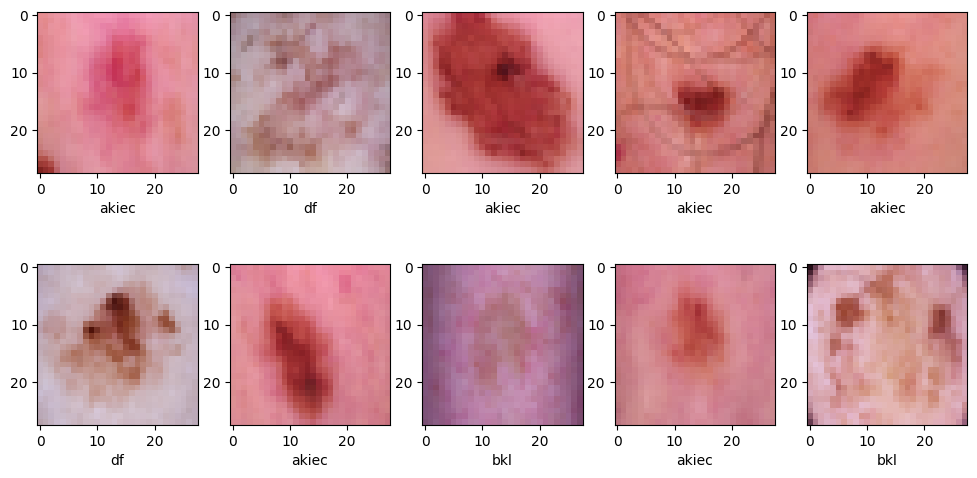

In [77]:
plt.figure(figsize=(12,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    idx = np.random.randint(0,5000)
    plt.imshow(np.array(df)[idx][:-1].reshape(28,28,3), interpolation='nearest')
    plt.xlabel(list(classes.keys())[np.array(df)[idx][-1]])

In [66]:
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weights = torch.from_numpy(class_weights)

## Data Prepocessing

In [ ]:
def DataLoader(X_train,y_train,batch_size=64):
    """Split data into batch"""
    n = X_train.shape[0]
    idx = torch.randperm(n)
    X_new,y_new = X_train[idx],y_train[idx]
    for i in range(0,n,batch_size):
        begin,end = i, min(i+batch_size,n)
        yield X_new[begin:end],y_new[begin:end]

def FitModel(X_train,X_test,y_train,y_test,model,criterion,optimizer,epoch,batch_size):
    train_acc_list = []
    val_acc_list   = []
    for e in range(epoch):
        total_loss = 0
        for x,y in DataLoader(X_train,y_train,batch_size):
            y_pred = model.forward(x)
            loss = criterion(y_pred,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss.detach().item()
            # print(loss.detach().item())
        total_loss /= int(X_train.shape[0] / batch_size)
        with torch.no_grad():
            y_train_pred = model.forward(X_train)
            y_test_pred  = model.forward(X_test)
            train_acc = torch.mean((torch.argmax(y_train_pred,dim=1)==torch.argmax(y_train,dim=1)) * 1.0)
            val_acc   = torch.mean((torch.argmax(y_test_pred,dim=1)==torch.argmax(y_test,dim=1)) * 1.0)
            print(f'EPOCH {e:>5} | LOSS: {total_loss:.4f} | TRAIN ACC: {train_acc* 100:.2f}% | VAL ACC: {val_acc*100:.2f}% |')
    
    Plot(train_acc_list,val_acc_list)

def Plot(train_acc_list,train_val_list):
    pass

## ANN

In [ ]:
ann_model = nn.Sequential(
    nn.Linear(28*28*3,128),
    nn.ReLU(),
    nn.Linear(128,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,7)
)
optimizer2 = torch.optim.Adam(ann_model.parameters(),lr=1e-3)
criterion2 = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# FitModel(X_train,X_test,y_train,y_test,
#          model=ann_model,
#          criterion=criterion2,
#          optimizer=optimizer2,
#          epoch=20,
#          batch_size=64)

## CNN

In [ ]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3)),
    nn.ReLU(),
    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)),
    nn.ReLU(),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(p=0.5),
    nn.Flatten(1),
    nn.Linear(1024,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(32,7)



)
optimizer = torch.optim.Adam(cnn_model.parameters(),lr=2.5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
FitModel(X_train.view(-1,3,28,28),X_test.view(-1,3,28,28),y_train,y_test,
         model=cnn_model,
         criterion=criterion,
         optimizer=optimizer,
         epoch=100,
         batch_size=32)

EPOCH     0 | LOSS: 1.9408 | TRAIN ACC: 2.92% | VAL ACC: 3.39% |
EPOCH     1 | LOSS: 1.9217 | TRAIN ACC: 55.67% | VAL ACC: 54.67% |
EPOCH     2 | LOSS: 1.8588 | TRAIN ACC: 41.65% | VAL ACC: 41.74% |
EPOCH     3 | LOSS: 1.8239 | TRAIN ACC: 41.49% | VAL ACC: 41.74% |
EPOCH     4 | LOSS: 1.8053 | TRAIN ACC: 30.82% | VAL ACC: 32.35% |
EPOCH     5 | LOSS: 1.7951 | TRAIN ACC: 44.23% | VAL ACC: 44.63% |
EPOCH     6 | LOSS: 1.7913 | TRAIN ACC: 35.50% | VAL ACC: 34.95% |
EPOCH     7 | LOSS: 1.7687 | TRAIN ACC: 41.60% | VAL ACC: 41.59% |
EPOCH     8 | LOSS: 1.7456 | TRAIN ACC: 46.42% | VAL ACC: 46.03% |
EPOCH     9 | LOSS: 1.7282 | TRAIN ACC: 47.63% | VAL ACC: 46.88% |
EPOCH    10 | LOSS: 1.7114 | TRAIN ACC: 42.75% | VAL ACC: 43.33% |
